<h1> 1.Problem Statement</h1>


- The task is to come up with a good prediction model for judging whether or not a vehicle faces imminent failure of the specific component or not. 
- It will help in repairing of the vehical, if we know the part due to which the failure has accored.

<h2> 1.1 Dataset Description </h2>

<p>The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurised air that are utilized in various functions in a truck, 
such as braking and gear changes. The datasets' positive class consists of component failures 
for a specific component of the APS system. The negative class consists of trucks with failures 
for components not related to the APS. The data consists of a subset of all available data, selected by experts. The attribute names of the data have been anonymized for 
proprietary reasons.</p>

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://ida2016.blogs.dsv.su.se/?page_id=1387

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
3. No strict latency concerns.
4. Interpretability is partially important.
5. Metric : score = 500*FN + 10*FP

<h1>2. Machine Learning Probelm </h1>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 172 columns:<br>
- Number of rows in Train.csv = 60,000
</p>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for the attribute we have to predict wwhether the failure has accoured due to some specific part or not.</p>

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

In [1]:
#library for imputation : https://pypi.org/project/impyute/
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from statsmodels.imputation import mice
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
import impyute
import xgboost as xgb
import pickle
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
import seaborn as sns
from prettytable import PrettyTable

Using TensorFlow backend.


In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
dp = data

In [5]:
data['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

### NOTE-> From the above result we can see that our data set is highly imbalanced, so simple accuracy score will not be a good measure of performance

In [6]:
Negative= data.loc[data['class'] == 'neg']  #extracting all the rows having negative class

In [7]:
Positive = data.loc[data['class']=='pos']  # extracting all the rows having positive class

## Counting NAN values in all the columns corresponding to both the classes

In [8]:
def countna(x):
    count = 0
    for i in x:
        if i=='na':
            count = count+1
    return count

In [9]:
y1 = Negative['class']
y2 = Positive['class']

In [10]:
pos = Positive.drop(['class'],axis=1)
neg = Negative.drop(['class'],axis=1)

In [11]:
columns = pos.columns
count_na_n = {}  # counting nan for negative class
count_na_p = {}  # counting nan for positive class
for c_name in columns:
    count_na_n[c_name] = countna(neg[c_name].values)
for c_name in columns:
    count_na_p[c_name] = countna(pos[c_name].values)

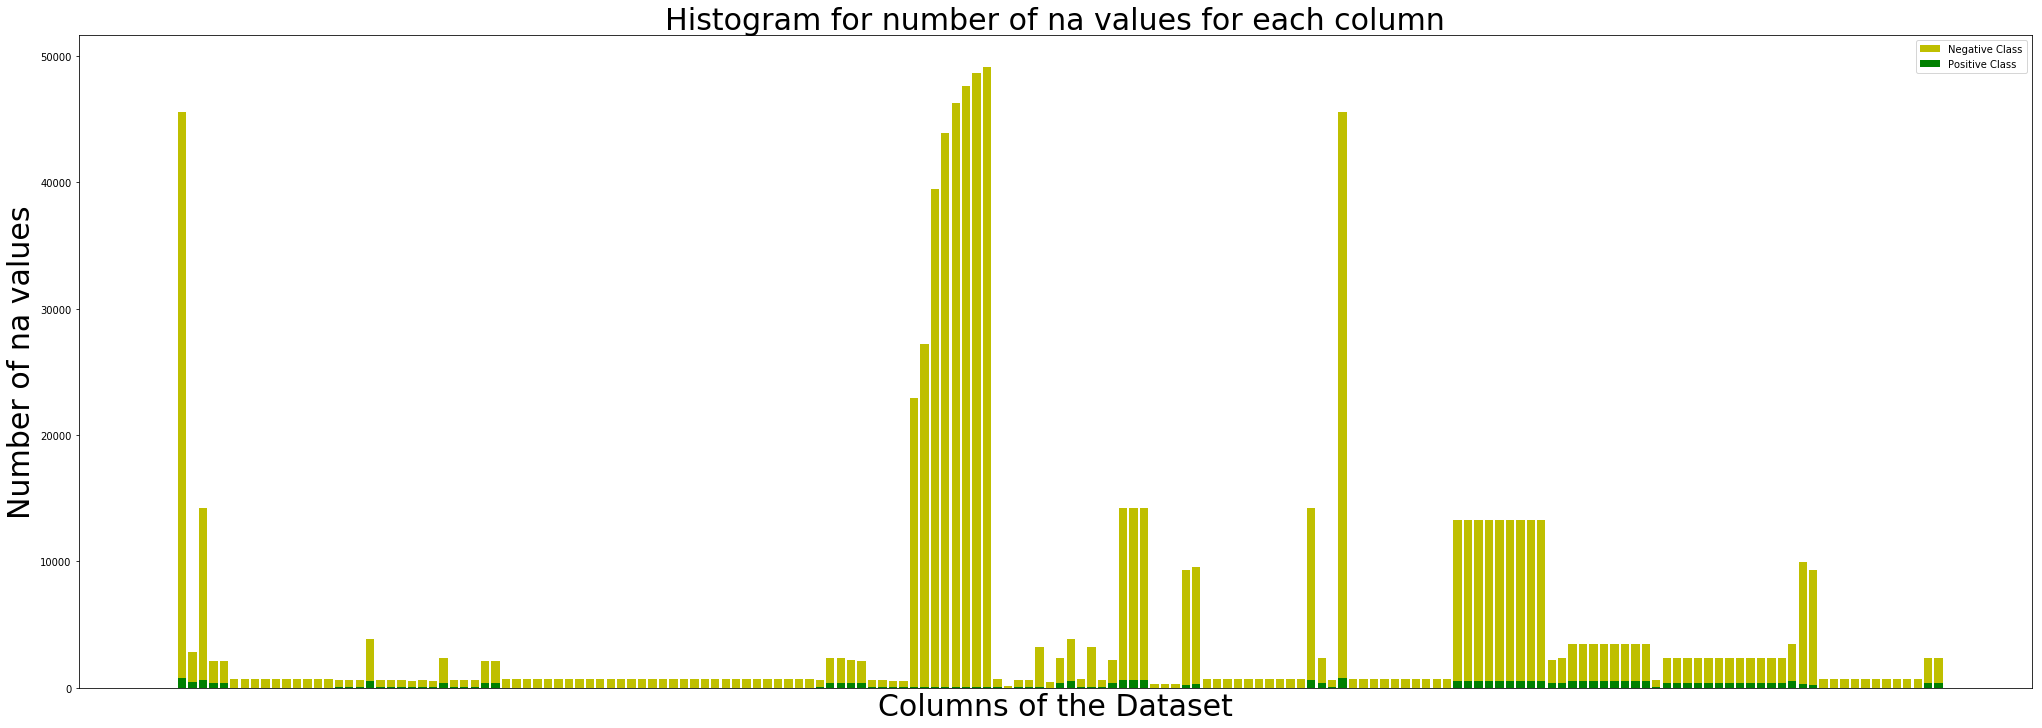

In [12]:
plt.figure(figsize=(35,12))
plt.bar(count_na_n.keys(), count_na_n.values(),color='y')
plt.bar(count_na_p.keys(), count_na_p.values(),color='g')
plt.xticks([])
plt.xlabel("Columns of the Dataset",size=30)
plt.ylabel("Number of na values",size = 30)
plt.title("Histogram for number of na values for each column",size =30)
plt.legend(['Negative Class','Positive Class'])
plt.show()

1. we can not sort the nan values as after doing sorting relative ordering of positive class columns and negative class relative ordering will change.
2. From the above histogram plot we can see that there are some columns in positive class that are having very few NAN but negative class is having lot of nan in those columns.

## Percentage Number of nan values in positive and negative class in each column

In [13]:
def calperpos(d):
    per_p = {}
    for val in d.keys():
        per_p[val] = (d[val]*100)/1000.0
    return per_p
percentage_p = calperpos(count_na_p)

In [14]:
def calperneg(d):
    per_n = {}
    for val in d.keys():
        per_n[val] = (d[val]*100)/59000.0
    return per_n
percentage_n = calperneg(count_na_n)

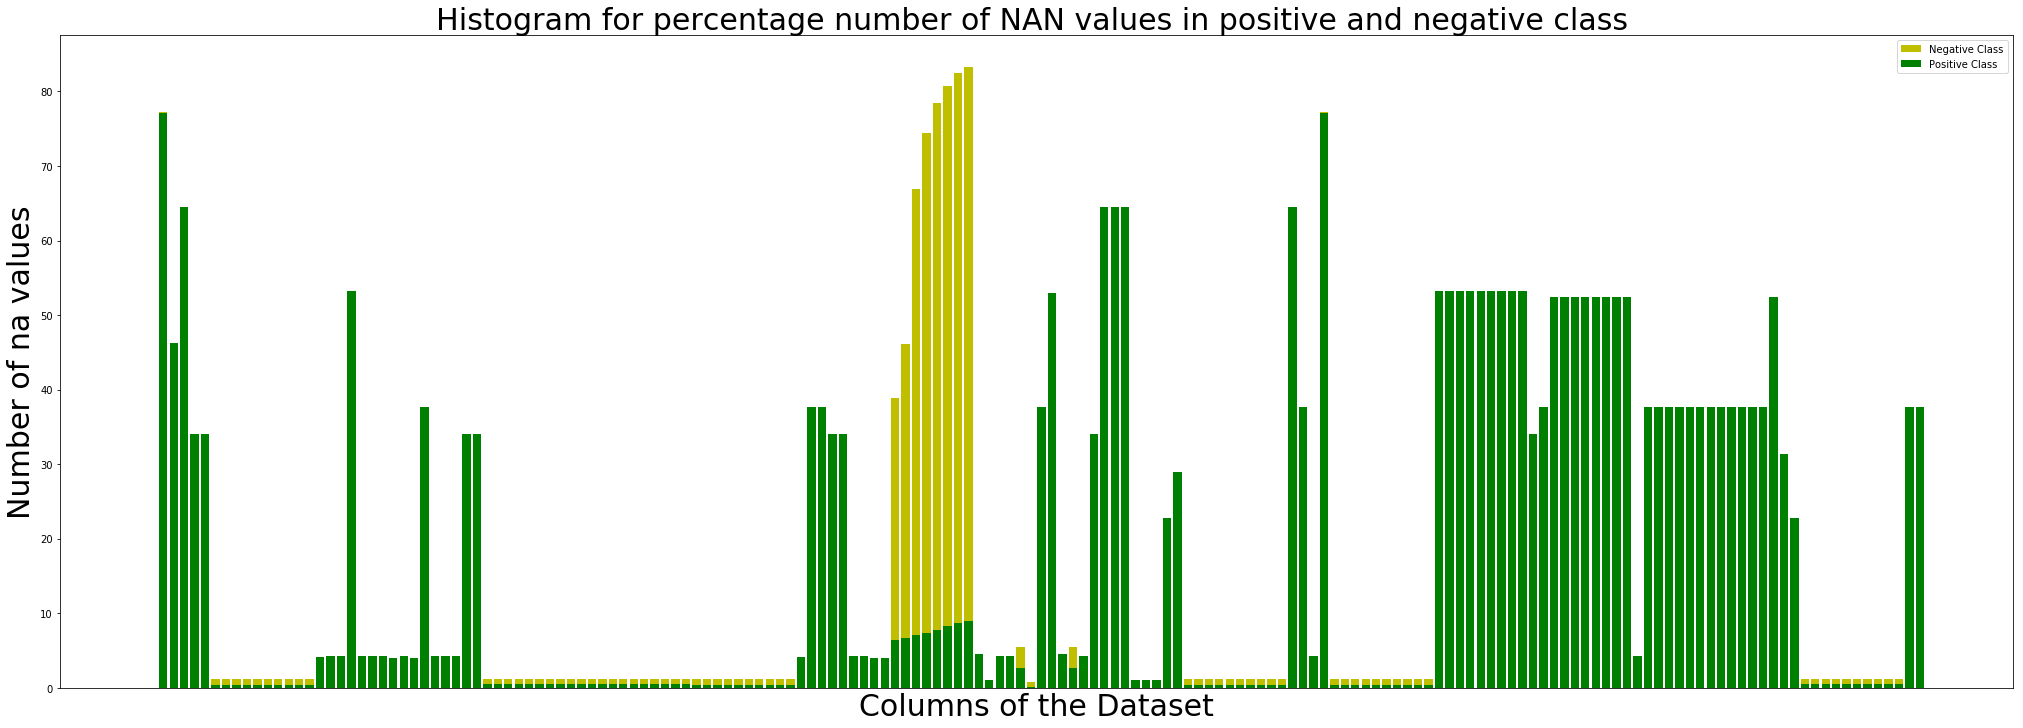

In [15]:
plt.figure(figsize=(35,12))
plt.bar(percentage_n.keys(), percentage_n.values(),color='y')
plt.bar(percentage_p.keys(), percentage_p.values(),color='g')
plt.xticks([])
plt.xlabel("Columns of the Dataset",size=30)
plt.ylabel("Number of na values",size = 30)
plt.title("Histogram for percentage number of NAN values in positive and negative class ",size =30)
plt.legend(['Negative Class','Positive Class'])
plt.show()

1. From the above histogram we can see that there is not equal percentage distribution of nan values in both positive and negative class. 
2. In positive class, more number of columns are having high percentage of nan values as compare to negative class. In negative class a bunch of columns are having most of the nan values. But in positive it is distributed accross the columns.  

## count na or missing values in all the columns

In [16]:
def countna(x):
    count = 0
    for i in x:
        if i=='na':
            count = count+1
    return count

In [17]:
y = data['class']

In [18]:
data = data.drop(['class'],axis=1)

In [19]:
columns = data.columns
count_na = {}
for c_name in columns:
    count_na[c_name] = countna(data[c_name].values)

In [20]:
sorted_d = sorted(count_na.items(), key=lambda x: x[1])

In [21]:
def Reverse(lst): 
    return [ele for ele in reversed(lst)] 
sorted_d = Reverse(sorted_d)

In [22]:
count_na = {}
for kv in sorted_d:
    count_na[kv[0]] = kv[1]

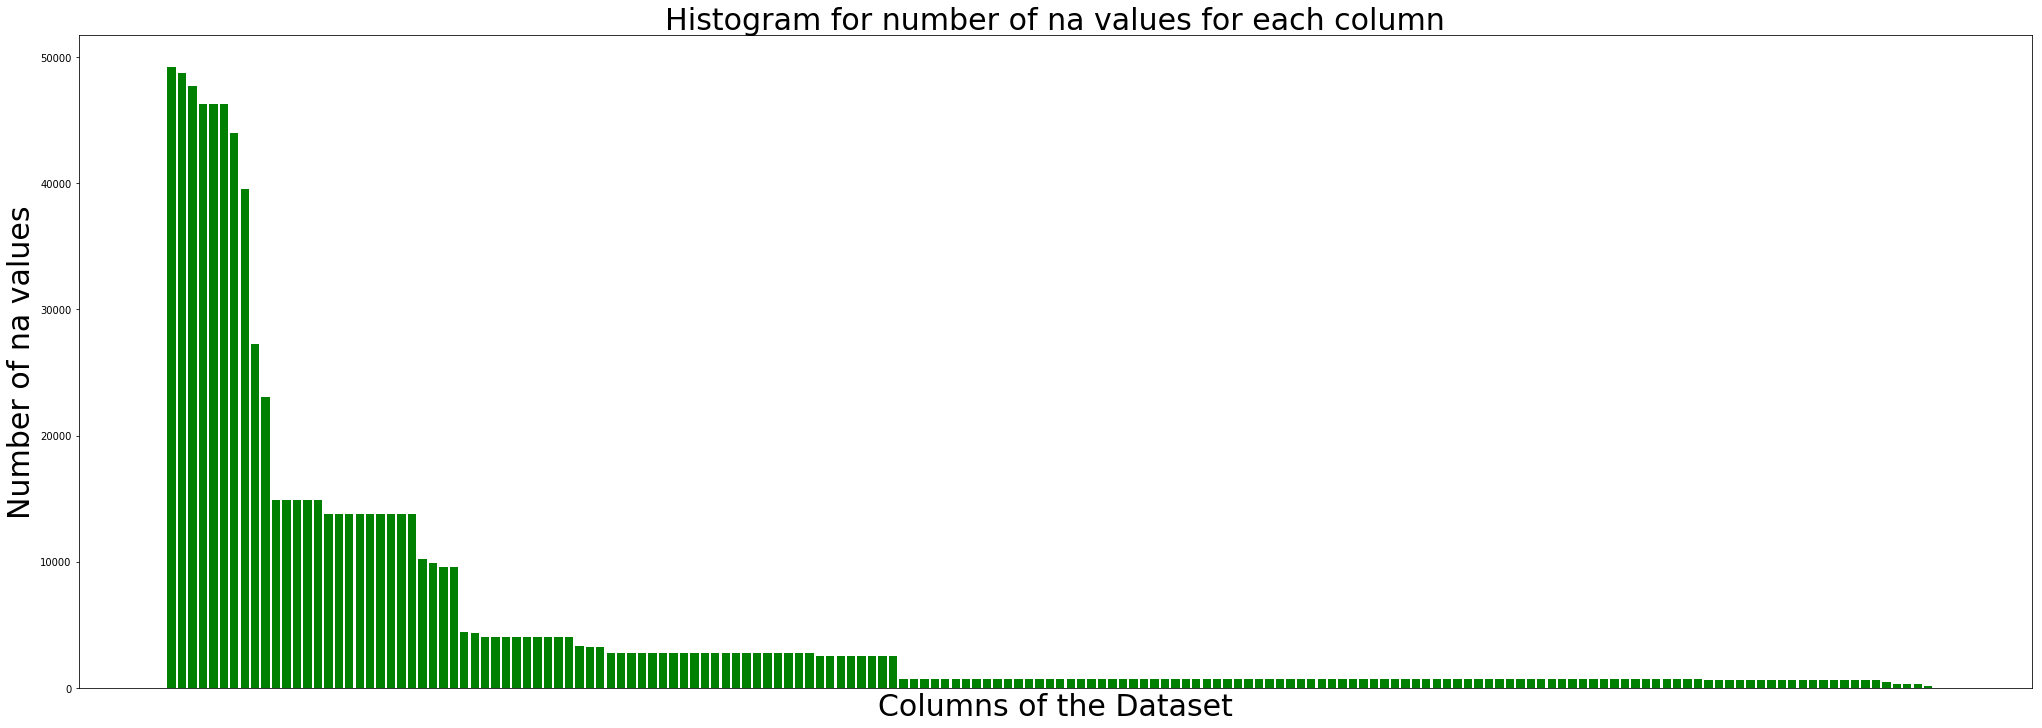

In [23]:
plt.figure(figsize=(35,12))
plt.bar(count_na.keys(), count_na.values(),color='g')
plt.xticks([])
plt.xlabel("Columns of the Dataset",size=30)
plt.ylabel("Number of na values",size = 30)
plt.title("Histogram for number of na values for each column",size =30)
plt.show()

## Zoom into the high number of NAN AREA

In [24]:
 sorted_d = sorted_d[:50]

In [25]:
count_na = {}
for kv in sorted_d:
    count_na[kv[0]] = kv[1]

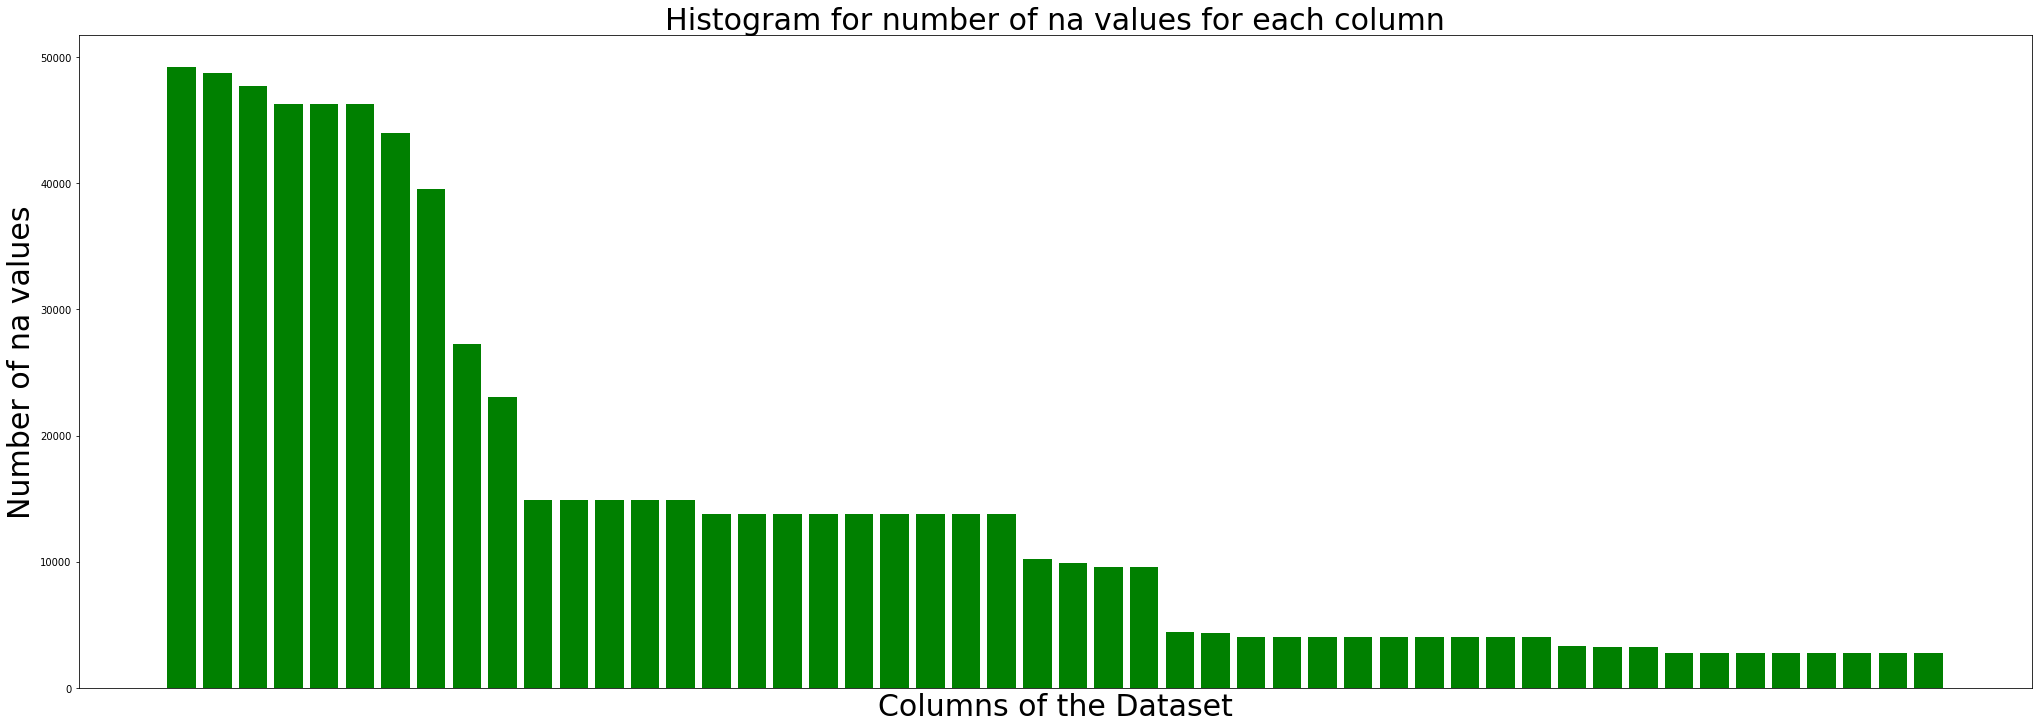

In [26]:
plt.figure(figsize=(35,12))
plt.bar(count_na.keys(), count_na.values(),color='g')
plt.xticks([])
plt.xlabel("Columns of the Dataset",size=30)
plt.ylabel("Number of na values",size = 30)
plt.title("Histogram for number of na values for each column",size =30)
plt.show()

In [27]:
 sorted_d = sorted_d[:25]

In [28]:
count_na = {}
for kv in sorted_d:
    count_na[kv[0]] = kv[1]

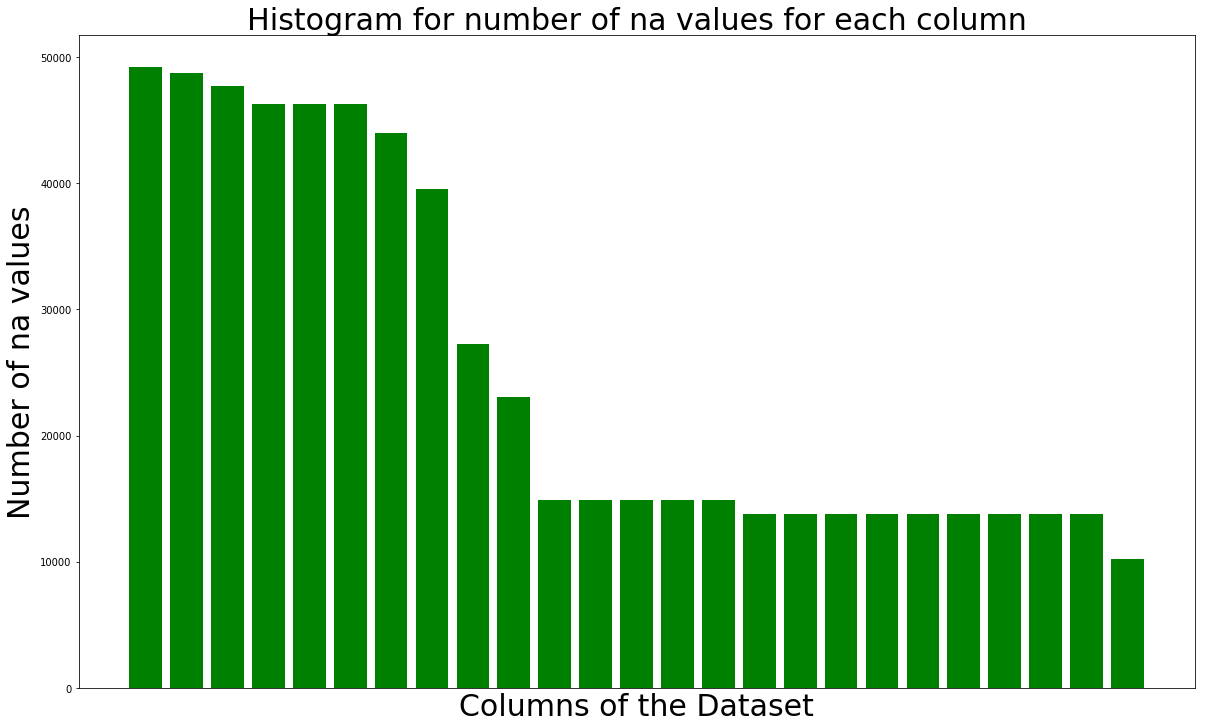

In [29]:
plt.figure(figsize=(20,12))
plt.bar(count_na.keys(), count_na.values(),color='g')
plt.xticks([])
plt.xlabel("Columns of the Dataset",size=30)
plt.ylabel("Number of na values",size = 30)
plt.title("Histogram for number of na values for each column",size =30)
plt.show()

1. From the above plot we can see that there are some attributes in the dataset for which more than 50% cells are NAN so we will drop those columns

## Percentage na value

In [30]:
per_count = {}
for i in count_na.keys():
    val = count_na[i]
    per = (val/60000)*100
    if per>=50:
        per_count[i]=per

In [31]:
print("Columns having more that 50% missing or na values and thier percentage :")
per_count

Columns having more that 50% missing or na values and thier percentage :


{'br_000': 82.10666666666665,
 'bq_000': 81.20333333333333,
 'bp_000': 79.56666666666666,
 'bo_000': 77.22166666666666,
 'cr_000': 77.215,
 'ab_000': 77.215,
 'bn_000': 73.34833333333334,
 'bm_000': 65.915}

1. From the above result we can see that there are 8 columns that are having more that 50% values as na so we will simply drop them from the dataset

In [32]:
## Droping the columns having more than 50% na values
data = data.drop(['ab_000','bm_000','bn_000','bo_000','bp_000','bq_000','br_000','cr_000'],axis=1)
print("After droping the columns having 50% or more missing values shape of the dataset",data.shape)

After droping the columns having 50% or more missing values shape of the dataset (60000, 162)


## Using simple mean for data imputation

In [33]:
data.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,2130706438,280,0,0,0,0,0,0,37250,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,0,na,0,0,0,0,0,0,18254,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,228,100,0,0,0,0,0,0,1648,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,70,66,0,10,0,0,0,318,2212,...,240,46,58,44,10,0,0,0,4,32
4,60874,1368,458,0,0,0,0,0,0,43752,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [34]:
data.dtypes

aa_000     int64
ac_000    object
ad_000    object
ae_000    object
af_000    object
ag_000    object
ag_001    object
ag_002    object
ag_003    object
ag_004    object
ag_005    object
ag_006    object
ag_007    object
ag_008    object
ag_009    object
ah_000    object
ai_000    object
aj_000    object
ak_000    object
al_000    object
am_0      object
an_000    object
ao_000    object
ap_000    object
aq_000    object
ar_000    object
as_000    object
at_000    object
au_000    object
av_000    object
           ...  
dl_000    object
dm_000    object
dn_000    object
do_000    object
dp_000    object
dq_000    object
dr_000    object
ds_000    object
dt_000    object
du_000    object
dv_000    object
dx_000    object
dy_000    object
dz_000    object
ea_000    object
eb_000    object
ec_00     object
ed_000    object
ee_000    object
ee_001    object
ee_002    object
ee_003    object
ee_004    object
ee_005    object
ee_006    object
ee_007    object
ee_008    object
ee_009    obje

In [35]:
#function to convert all the data columns to numeric
def convert_numeric(x):
    d = []
    for y in x:
        if y=='na':
            d.append(np.nan)
        else:
            d.append(float(y))
    return d

In [36]:
## Converting all columns to numeric:
cl = data.columns
num_data = pd.DataFrame()
for d in range(0,len(cl)):
        num_data[cl[d]] = convert_numeric(data[cl[d]].values)

In [37]:
num_data.shape

(60000, 162)

### performing imputation using soft impute method
1. Soft  impute  iteratively  computes  the  soft  thresholder SVDof a filled in matrix. It works well and fast for datasets  with  high  dimensionality. As our dataset is also high dimensional so we are using it.

In [101]:
X_incomplete_normalized = BiScaler().fit_transform(num_data.values)
X_filled = SoftImpute().fit_transform(X_incomplete_normalized)

[BiScaler] Initial log residual value = 42.207541
[BiScaler] Iter 1: log residual = 11.864575, log improvement ratio=30.342966
[BiScaler] Iter 2: log residual = 12.129577, log improvement ratio=-0.265002
[SoftImpute] Max Singular Value of X_init = 1319.682836
[SoftImpute] Iter 1: observed MAE=0.036963 rank=141
[SoftImpute] Iter 2: observed MAE=0.036945 rank=141
[SoftImpute] Iter 3: observed MAE=0.036948 rank=141
[SoftImpute] Iter 4: observed MAE=0.036955 rank=141
[SoftImpute] Iter 5: observed MAE=0.036959 rank=141
[SoftImpute] Iter 6: observed MAE=0.036961 rank=141
[SoftImpute] Iter 7: observed MAE=0.036960 rank=141
[SoftImpute] Iter 8: observed MAE=0.036957 rank=141
[SoftImpute] Iter 9: observed MAE=0.036953 rank=141
[SoftImpute] Iter 10: observed MAE=0.036948 rank=141
[SoftImpute] Iter 11: observed MAE=0.036943 rank=141
[SoftImpute] Iter 12: observed MAE=0.036938 rank=141
[SoftImpute] Iter 13: observed MAE=0.036934 rank=141
[SoftImpute] Iter 14: observed MAE=0.036930 rank=141
[SoftIm

In [213]:
## saving the imputated data to the pickle file for future use
#pickle_out = open("soft_impute.pickle","wb")
#pickle.dump(X_filled, pickle_out)
#pickle_out.close()

In [38]:
pickle_in = open("soft_impute.pickle","rb")
X_filled = pickle.load(pickle_in)

In [39]:
data = pd.DataFrame(X_filled)

In [40]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.158453,0.306563,-0.027281,-0.267232,-0.226352,-0.023436,-0.033543,-0.050320,-0.064121,-0.061247,...,1.038833,0.680803,0.279360,0.150360,0.135379,0.002087,-0.051402,-0.060995,-0.357204,-0.357745
1,-1.609843,-0.720129,0.124447,0.954120,0.667691,-0.046514,-0.215173,-0.557550,-0.757257,-0.886110,...,1.410218,0.501847,-0.452577,-0.575740,-1.006408,-0.929701,-0.343489,-0.578808,1.707113,1.702658
2,-1.257908,-0.931592,-0.434188,-0.326303,-0.404908,-0.147734,-0.347400,-0.735946,-0.980600,-1.328223,...,-0.655354,0.082158,0.901853,1.486646,1.773272,0.033597,-0.479026,-0.869123,-0.041128,-0.047634
3,-0.685887,-0.116120,-0.054384,0.163228,0.228466,-0.006974,-0.034282,-0.089816,-0.119329,-0.164770,...,-0.676363,-0.607931,-0.489023,-0.508648,-0.436113,-0.312578,-0.226681,-0.115825,0.369060,0.930466
4,0.135927,-0.159604,-0.067947,-0.323641,-0.287024,-0.040333,-0.071363,-0.128603,-0.168169,-0.148630,...,0.904169,0.386191,0.118029,0.109380,0.208599,0.428790,0.735449,-0.134675,-0.392976,-0.394219


In [41]:
## Converting Y values as Numeric
d_class = []
for d in y.values:
    if d=='neg':
        d_class.append(0)
    else:
        d_class.append(1)

In [42]:
data['class'] = d_class

In [43]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,class
0,0.158453,0.306563,-0.027281,-0.267232,-0.226352,-0.023436,-0.033543,-0.050320,-0.064121,-0.061247,...,0.680803,0.279360,0.150360,0.135379,0.002087,-0.051402,-0.060995,-0.357204,-0.357745,0
1,-1.609843,-0.720129,0.124447,0.954120,0.667691,-0.046514,-0.215173,-0.557550,-0.757257,-0.886110,...,0.501847,-0.452577,-0.575740,-1.006408,-0.929701,-0.343489,-0.578808,1.707113,1.702658,0
2,-1.257908,-0.931592,-0.434188,-0.326303,-0.404908,-0.147734,-0.347400,-0.735946,-0.980600,-1.328223,...,0.082158,0.901853,1.486646,1.773272,0.033597,-0.479026,-0.869123,-0.041128,-0.047634,0
3,-0.685887,-0.116120,-0.054384,0.163228,0.228466,-0.006974,-0.034282,-0.089816,-0.119329,-0.164770,...,-0.607931,-0.489023,-0.508648,-0.436113,-0.312578,-0.226681,-0.115825,0.369060,0.930466,0
4,0.135927,-0.159604,-0.067947,-0.323641,-0.287024,-0.040333,-0.071363,-0.128603,-0.168169,-0.148630,...,0.386191,0.118029,0.109380,0.208599,0.428790,0.735449,-0.134675,-0.392976,-0.394219,0


### Splitting the datainto train test and cv 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['class'],axis=1),data['class'], test_size=0.20, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.20, random_state=42)

In [45]:
## method to create the heat map for cross validation 
def createHeatMap(alpha,gamma1,roc_auc_cv1):
    l = []
    for i in alpha:
        for g in gamma1:
            l.append([i,g])
    l = np.asarray(l)
    df = pd.DataFrame(l, columns=['depth','estimators'])
    df['cv_score'] = roc_auc_cv1
    df.head()
    sns.set()
    data = df.pivot("depth", "estimators", "cv_score")
    ax = sns.heatmap(data, annot=True, fmt=".3f")

## Naive Bayes
1. As we know naive works well when dimensionality of the dataset is large, Naive Bayes performs well. So we are using naive on this dataset as well.

In [42]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
predict_train = gnb.predict(X_train)
predict_test = gnb.predict(X_test)
print("Train Accuracy score of the model :",accuracy_score(y_train,predict_train))
print("Test Accuracy score of the model :",accuracy_score(y_test,predict_test))

Train Accuracy score of the model : 0.8571614583333333
Test Accuracy score of the model : 0.85325


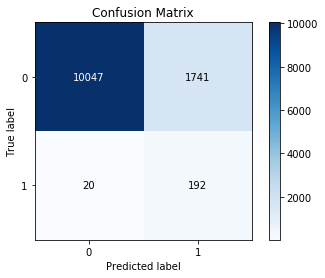

In [33]:
#confusion matrix for test data
skplt.metrics.plot_confusion_matrix(y_test,predict_test)

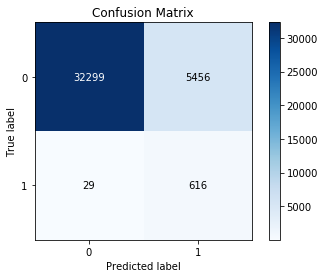

In [34]:
##confusiion matrix for train data
skplt.metrics.plot_confusion_matrix(y_train,predict_train)

In [35]:
train_score = 29*500+5456*10
test_score = 20*500+1741*10
print("Training score using given metric : ",train_score)
print("Test score using given metric :",test_score)

Training score using given metric :  69060
Test score using given metric : 27410


## Random Forest Classifier

In [67]:
# Reference: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    return [TP, FP, TN, FN]

In [36]:
depth=[1,10,30, 100,300]
est=[1,10,50,150,200]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_est = 0
opt_depth = 0
opt_val_cv = 99999999999999999999999
opt_val_train = 0
train_val = []
cv_val = []
for d in depth:
    for s in est:
        clf = RFC(n_estimators = 1,max_depth = 1,n_jobs=-1)
        clf.fit(X_train,y_train)
        cv_prediction = clf.predict_proba(X_cv)[:,1]
        train_prediction = clf.predict_proba(X_train)[:,1]
        cv_prediction1 = clf.predict(X_cv)
        train_prediction1 = clf.predict(X_train)
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        ## calculating fp,pn,tn,tp
        X1 = perf_measure(y_cv.values,cv_prediction1)
        X2 = perf_measure(y_train.values,train_prediction1)
        v1 = X1[3]*10 + X1[1]*500
        v2 = X2[3]*10 + X2[1]*500
        train_val.append(v2)
        cv_val.append(v1)
        #skplt.metrics.plot_confusion_matrix(y_cv,cv_prediction1)
        if(opt_val_cv > v1):
            opt_val_cv = v1
            opt_val_train = v2
            opt_depth = d
            opt_sample_est = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Optimal Cross Validation Error : ",opt_val_cv)
print("Train Error on Optimal CV Error : ",opt_val_train)
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal No of estimators:",opt_sample_est)

NameError: name 'perf_measure' is not defined

####  Heat map for error (500*FN+10*FP)

Heat Map on CV data:


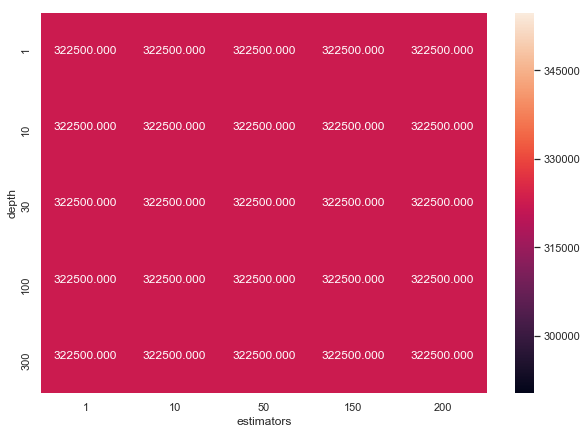

In [111]:
plt.figure(figsize=(10,7))
print("Heat Map on train data:")
createHeatMap(depth,est,train_val)

Heat Map for Training data:


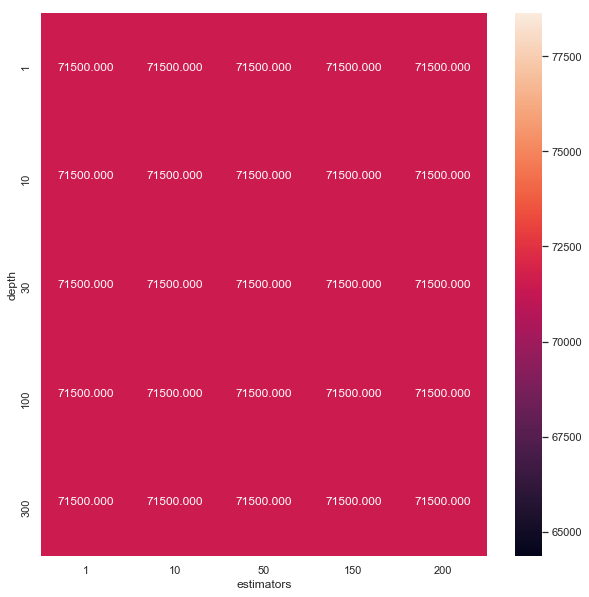

In [112]:
plt.figure(figsize=(10,10))
print("Heat Map for Training data:")
createHeatMap(depth,est,cv_val)

#### CV Score

Heat Map on CV data:


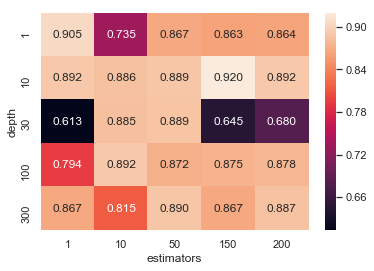

In [114]:
print("Heat Map on CV data:")
createHeatMap(depth,est,roc_auc_cv)

Heat Map for Training data:


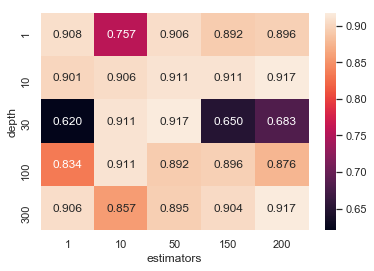

In [115]:
print("Heat Map for Training data:")
createHeatMap(depth,est,roc_auc_train)

In [116]:
# as at c = 1000 we are overfitting so we will use c = 100
clf = RFC(n_estimators = 1,max_depth = 1,n_jobs=-1)
clf.fit(X_train,y_train)
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
print("Train Accuracy of the model : ",accuracy_score(y_train,predict_train))
print("Test accuracy of the model :",accuracy_score(y_test,predict_test))

Train Accuracy of the model :  0.983203125
Test accuracy of the model : 0.9823333333333333


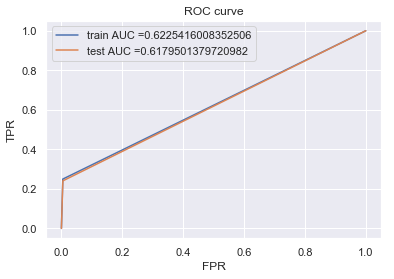

In [117]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds1 = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(metrics.auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(metrics.auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

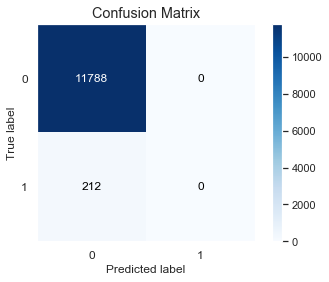

In [118]:
#confusion matrix for test data
skplt.metrics.plot_confusion_matrix(y_test,predict_test)

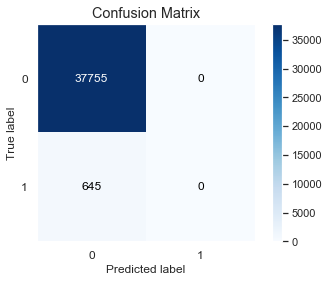

In [119]:
##confusiion matrix for train data
skplt.metrics.plot_confusion_matrix(y_train,predict_train)

In [133]:
test_score = 500*212+0*10
train_score = 645*500+0*10
print("Training score using given metric : ",train_score)
print("Test score using given metric :",test_score)

Training score using given metric :  322500
Test score using given metric : 106000


### XGboost Model

In [122]:
depth=[1,10,30,100,200]
est=[1,10,50,150,300]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_est = 0
opt_depth = 0
train_val,cv_val = [],[]
opt_val_cv,opt_val_train = 9999999999999999999999,0
for d in depth:
    for s in est:
        clf = xgb.XGBClassifier(n_estimators = s,max_depth = d,n_jobs = -1)
        clf.fit(X_train,y_train)
        cv_prediction = clf.predict_proba(X_cv)[:,1]
        train_prediction = clf.predict_proba(X_train)[:,1]
        cv_prediction1 = clf.predict(X_cv)
        train_prediction1 = clf.predict(X_train)
        cv_auc = roc_auc_score(y_cv, cv_prediction)
        train_acc = roc_auc_score(y_train,train_prediction)
        ## calculating fp,pn,tn,tp
        X1 = perf_measure(y_cv.values,cv_prediction1)
        X2 = perf_measure(y_train.values,train_prediction1)
        v1 = X1[3]*500 + X1[1]*10
        v2 = X2[3]*500 + X2[1]*10
        train_val.append(v2)
        cv_val.append(v1)
        #skplt.metrics.plot_confusion_matrix(y_cv,cv_prediction1)
        if(opt_val_cv > v1):
            opt_val_cv = v1
            opt_val_train = v2
            opt_depth = d
            opt_sample_est = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Optimal Cross Validation Error : ",opt_val_cv)
print("Train Error on Optimal CV Error : ",opt_val_train)
print("Max ROC_AUC Score :",max_auc)
print("Optimal_depth of the decision tree :",opt_depth)
print("Optimal No of estimators:",opt_sample_est)

Optimal Cross Validation Error :  24070
Train Error on Optimal CV Error :  0
Max ROC_AUC Score : 0.9948652383885545
Optimal_depth of the decision tree : 30
Optimal No of estimators: 300


### heat map for error

Heat Map on train data:


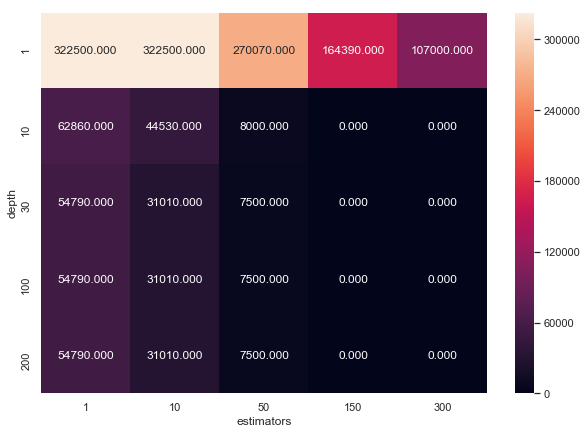

In [124]:
plt.figure(figsize=(10,7))
print("Heat Map on train data:")
createHeatMap(depth,est,train_val)

Heat Map on CV data:


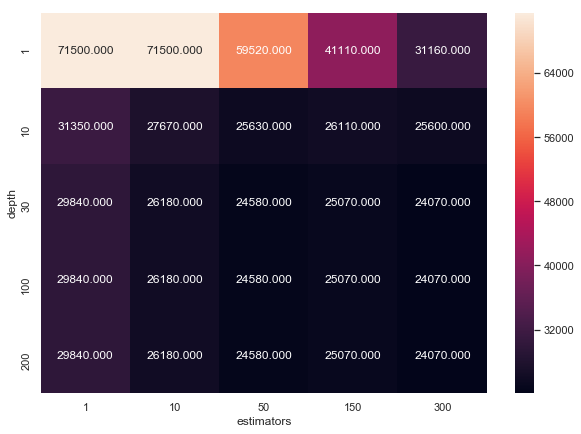

In [126]:
plt.figure(figsize=(10,7))
print("Heat Map on CV data:")
createHeatMap(depth,est,cv_val)

### Heat map for auc_roc score

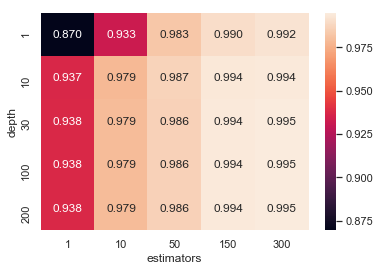

In [127]:
createHeatMap(depth,est,roc_auc_cv)

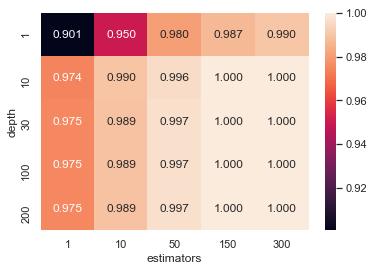

In [128]:
createHeatMap(depth,est,roc_auc_train)

In [129]:
clf = xgb.XGBClassifier(n_estimators = 300,max_depth = 30,n_jobs = -1)
clf.fit(X_train,y_train)
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
print("Train Accuracy of the model : ",accuracy_score(y_train,predict_train))
print("Test accuracy of the model :",accuracy_score(y_test,predict_test))

Train Accuracy of the model :  1.0
Test accuracy of the model : 0.9926666666666667


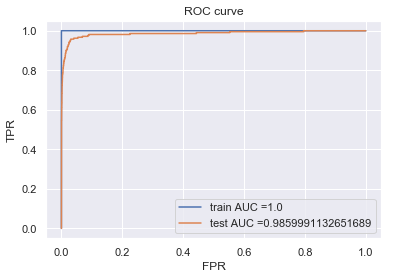

In [130]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds1 = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(metrics.auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(metrics.auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Confusion matrix for test data :
Confusion matrix for train data :


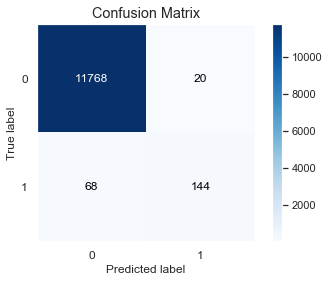

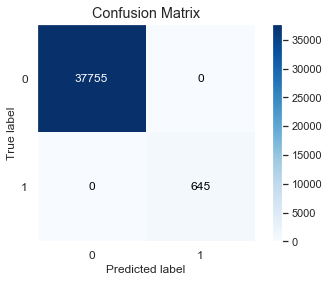

In [131]:
#confusion matrix for test data
print("Confusion matrix for test data :")
skplt.metrics.plot_confusion_matrix(y_test,predict_test)
##confusiion matrix for train data
print("Confusion matrix for train data :")
skplt.metrics.plot_confusion_matrix(y_train,predict_train)

In [132]:
train_score = 500*0+0*10
test_score = 68*500+20*10
print("Training score using given metric : ",train_score)
print("Test score using given metric :",test_score)

Training score using given metric :  0
Test score using given metric : 34200


## Conclusion

In [1]:
x = PrettyTable()
print("Using Expect Maximization for Imputation:")
x.field_names = (["Imputation Technique", "Train Accuracy","Test Accuracy","500*FN+10*FN Train","500*FN+10*TN Test", "Classifier"])
x.add_row(["Expect_Max", 0.9668, 0.96291, 47510,18170,"Naive Bayes"])
x.add_row(["Expect_Max",0.9814,.98,7120, 13620,"Random Forest"])
x.add_row(["Expect_Max",0.97289,.96225,10400,9430,"XGboost"])
print(x)


x = PrettyTable()
print("Using Mean for Imputation:")
x.field_names = (["Mean", "Train Accuracy","Test Accuracy","500*FN+10*FN Train","500*FN+10*TN Test", "Classifier"])
x.add_row(["Mean",0.9658,0.9619,50400,12370,"Naive Bayes"])
x.add_row(["Mean", 0.97,0.94975,10660,17020,"Random Forest"])
x.add_row(["Mean", 0.9739, 0.9636,9990, 9260,"XGboost"])
print(x)
x = PrettyTable()
print("Using Soft Impute for Imputation:")
x.field_names = (["Soft Impute", "Train Accuracy","Test Accuracy","500*FN+10*FN Train","500*FN+10*TN Test", "Classifier"])
x.add_row(["Soft Impute",0.8532,0.8571,69060,27410,"Naive Bayes"])
x.add_row(["Soft Impute",0.9832,.9823, 322500,106000,"Random Forest"])
x.add_row(["Soft Impute",1,0.99266,0, 34200,"XGboost"])
print(x)

NameError: name 'PrettyTable' is not defined

1. From the above table we can see that we are getting maximum accuracy .9929 for XHboost when using em as method for imputation
2. We are getting optimal 500*FN + 10*TN (16900) when using Navie Bayes when using Mean as method for imputation.

## Steps Taken

1. Download the dataset.
2. Check for the NAN values in the dataset.
3. Remove the columns having more than 50% values as NAN.
4. Fill the nan values using various methods such as Mean, Expect_Maximization, and Soft Impute.
5. Break the dataset into train test and cv.
6. Perform the hyperparameter tunning.
7. Conclude the result.